In [1]:
%matplotlib inline

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

Load Data
---------


In [3]:
path_root = './dataset/'

PATH_SAVE = "./models_mask"
MODEL = 'model_softmax'#.model'
MODEL_FT = MODEL + '_ft'
EPOCHS = 100
BATCH_SIZE = 8
NUM_WORKERS = 0

### Calculate the media and std of our dataset

In [4]:
train_dataset = torchvision.datasets.ImageFolder(path_root+'train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224), #224x224
                                                    transforms.ToTensor() # Convertir en un rango de 0-1
                                                ]))

print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 1972
    Root location: ./dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [5]:
%%time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(train_loader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute MEAN and VAR here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)

mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

tensor([0.5710, 0.5033, 0.4747])
tensor([0.2513, 0.2497, 0.2534])
CPU times: user 12.8 s, sys: 736 ms, total: 13.5 s
Wall time: 46.3 s


### Data augmentation and normalization for training

In [6]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256), #transforms.RandomResizedCrop(160),
        transforms.CenterCrop(224), #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.5737, 0.4802, 0.4410],[0.2369, 0.2243, 0.2235]) #([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize(mean.tolist()[0], std.tolist()[0])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.5737, 0.4802, 0.4410],[0.2369, 0.2243, 0.2235]) #([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize(mean.tolist()[0], std.tolist()[0])
    ]),
}

data_dir = path_root
print(os.path.join(data_dir, 'train'))

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

./dataset/train


In [7]:
dataset_sizes

{'train': 1972, 'test': 1053}

In [8]:
class_names

['mask', 'nomask']

Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



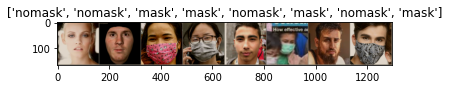

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Epoch: {}'.format(best_epoch))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Visualizing the model predictions**

Generic function to display predictions for a few images




In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.





In [12]:
class MaskNet(nn.Module):
    def __init__(self):
        super(MaskNet, self).__init__()
        #print("here")
        model_conv = torchvision.models.resnet34(pretrained=True)
        for param in model_conv.parameters():
            param.requires_grad = False
            
        num_ftrs = model_conv.fc.in_features
        model_conv.fc = nn.Linear(num_ftrs, 2)
        
        self.model=model_conv
    def forward(self, x):
        return self.model(x)

In [13]:
model_conv = MaskNet()
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

**Train and evaluate**

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
best_model_conv_ffe = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/99
----------


/Users/peterbonnesoeur/.local/share/virtualenvs/face-mask-detector-M6B6RECa/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2245 Acc: 0.9143
test Loss: 0.0901 Acc: 0.9696

Epoch 1/99
----------
train Loss: 0.1345 Acc: 0.9498
test Loss: 0.1328 Acc: 0.9535

Epoch 2/99
----------
train Loss: 0.1357 Acc: 0.9539
test Loss: 0.1282 Acc: 0.9497

Epoch 3/99
----------
train Loss: 0.1102 Acc: 0.9574
test Loss: 0.0626 Acc: 0.9791

Epoch 4/99
----------
train Loss: 0.0944 Acc: 0.9701
test Loss: 0.0708 Acc: 0.9753

Epoch 5/99
----------
train Loss: 0.0895 Acc: 0.9650
test Loss: 0.0648 Acc: 0.9782

Epoch 6/99
----------
train Loss: 0.0790 Acc: 0.9716
test Loss: 0.0772 Acc: 0.9725

Epoch 7/99
----------
train Loss: 0.0829 Acc: 0.9706
test Loss: 0.0708 Acc: 0.9734

Epoch 8/99
----------
train Loss: 0.0787 Acc: 0.9772
test Loss: 0.0714 Acc: 0.9725

Epoch 9/99
----------
train Loss: 0.0773 Acc: 0.9686
test Loss: 0.0653 Acc: 0.9791

Epoch 10/99
----------
train Loss: 0.0916 Acc: 0.9696


In [ ]:
visualize_model(best_model_conv_ffe)

plt.show()

In [ ]:
# Save Model
name_model = MODEL+'.model'
name_pkl = MODEL+'.pkl'

torch.save(best_model_conv_ffe, os.path.join(PATH_SAVE, name_model))
torch.save(best_model_conv_ffe.state_dict(), os.path.join(PATH_SAVE, name_pkl))

In [ ]:
# Load Model
#params = torch.load(name_model)
#loaded_conv_ffe.load_state_dict(params)

loaded_conv_ffe = torch.load(os.path.join(PATH_SAVE, name_model))

loaded_conv_ffe2 = MaskNet()
params = torch.load(os.path.join(PATH_SAVE, name_pkl))
loaded_conv_ffe2.load_state_dict(params)

loaded_conv_ffe.eval()

In [ ]:
# Iterate over data.
def fx_evaluate_model(model, dataset):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataset:
        with torch.set_grad_enabled(False):
            inputs = inputs.to(device)
            labels = labels.to(device)
       
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    value_loss = running_loss / len(dataset.dataset)
    value_acc = running_corrects.double() / len(dataset.dataset)

    print('Loss: {:4f}'.format(value_loss))
    print('Accuracy: {:4f}'.format(value_acc))

In [ ]:
fx_evaluate_model(model=loaded_conv_ffe, dataset=dataloaders['train'])

In [ ]:
fx_evaluate_model(model=loaded_conv_ffe, dataset=dataloaders['test'])